# Laptop price prediction
Source: https://platform.stratascratch.com/data-projects/laptop-price-prediction

## (1) Imports and setups

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import set_config
from xgboost import XGBRegressor, plot_importance

set_config(transform_output="pandas")

In [2]:
train_dt = pd.read_json("./datasets/train_dataset.json")
val_dt = pd.read_json("./datasets/val_dataset.json")
test_dt = pd.read_json("./datasets/test_dataset.json")

In [3]:
val_dt["buynow_price"]

3849    3829.0
3904    2786.5
8356    4269.0
6022    4239.0
9678    3799.0
         ...  
4433    7936.0
9242    2890.0
3982    2716.0
9673    4319.0
4277    3919.0
Name: buynow_price, Length: 1571, dtype: float64

In [4]:
print(train_dt.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4711 entries, 7233 to 6037
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   graphic card type       4417 non-null   object 
 1   communications          4261 non-null   object 
 2   resolution (px)         4361 non-null   object 
 3   CPU cores               4711 non-null   object 
 4   RAM size                4457 non-null   object 
 5   operating system        4335 non-null   object 
 6   drive type              4454 non-null   object 
 7   input devices           4321 non-null   object 
 8   multimedia              4310 non-null   object 
 9   RAM type                4212 non-null   object 
 10  CPU clock speed (GHz)   4181 non-null   float64
 11  CPU model               4389 non-null   object 
 12  state                   4711 non-null   object 
 13  drive memory size (GB)  4439 non-null   float64
 14  warranty                4711 non-null   ob

In [5]:
print(val_dt.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1571 entries, 3849 to 4277
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   graphic card type       1471 non-null   object 
 1   communications          1409 non-null   object 
 2   resolution (px)         1442 non-null   object 
 3   CPU cores               1571 non-null   object 
 4   RAM size                1478 non-null   object 
 5   operating system        1437 non-null   object 
 6   drive type              1485 non-null   object 
 7   input devices           1426 non-null   object 
 8   multimedia              1420 non-null   object 
 9   RAM type                1394 non-null   object 
 10  CPU clock speed (GHz)   1375 non-null   float64
 11  CPU model               1467 non-null   object 
 12  state                   1571 non-null   object 
 13  drive memory size (GB)  1467 non-null   float64
 14  warranty                1571 non-null   ob

In [6]:
print(test_dt.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1571 entries, 5124 to 1371
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   graphic card type       1469 non-null   object 
 1   communications          1401 non-null   object 
 2   resolution (px)         1442 non-null   object 
 3   CPU cores               1571 non-null   object 
 4   RAM size                1468 non-null   object 
 5   operating system        1431 non-null   object 
 6   drive type              1479 non-null   object 
 7   input devices           1428 non-null   object 
 8   multimedia              1415 non-null   object 
 9   RAM type                1383 non-null   object 
 10  CPU clock speed (GHz)   1361 non-null   float64
 11  CPU model               1464 non-null   object 
 12  state                   1571 non-null   object 
 13  drive memory size (GB)  1466 non-null   float64
 14  warranty                1571 non-null   ob

## (2) Data manipulation

In [7]:
def explode_and_pivot(df0, varname):
    df = df0.copy()
    df["id"] = df.index
    df = df[["id", varname]]
    df_exploded = df.explode(varname)
    df_exploded["flag"] = 1

    # Correcting some values
    if varname == "operating system":
        df_exploded[varname] = np.where(
            df_exploded[varname] == "other", "other OS", df_exploded[varname]
        )

    df_pivot = df_exploded.pivot_table(index="id", columns=varname, values="flag")
    df0 = df0.merge(
        df_pivot, how="left", left_index=True, right_index=True, validate="1:1"
    )
    return df0

In [8]:
train_dt = explode_and_pivot(train_dt, "input devices")
train_dt = explode_and_pivot(train_dt, "multimedia")
train_dt = explode_and_pivot(train_dt, "communications")
train_dt = explode_and_pivot(train_dt, "operating system")


In [9]:
val_dt = explode_and_pivot(val_dt, "input devices")
val_dt = explode_and_pivot(val_dt, "multimedia")
val_dt = explode_and_pivot(val_dt, "communications")
val_dt = explode_and_pivot(val_dt, "operating system")

In [10]:
test_dt = explode_and_pivot(test_dt, "input devices")
test_dt = explode_and_pivot(test_dt, "multimedia")
test_dt = explode_and_pivot(test_dt, "communications")
test_dt = explode_and_pivot(test_dt, "operating system")

In [11]:
def clean_df(df):
    df["graphic card type"] = df["graphic card type"].fillna("None")
    df["resolution (px)"] = pd.to_numeric(
        df["resolution (px)"].str.split("x").str[0], errors="coerce"
    )
    df["CPU cores"] = pd.to_numeric(df["CPU cores"], errors="coerce")
    df["RAM size"] = pd.to_numeric(
        df["RAM size"].str.split(" ").str[0], errors="coerce"
    )
    df["screen size"] = pd.to_numeric(
        df["screen size"].str.split('"').str[0], errors="coerce"
    )

    df["wifi_n"] = np.maximum(df["wi-fi 802.11 a/b/g/n"], df["wi-fi 802.11 b/g/n"])
    df["wifi_ac"] = np.maximum(
        df["wi-fi 802.11 a/b/g/n/ac"], df["wi-fi 802.11 b/g/n/ac"]
    )

    df = df.drop(
        columns=[
            "wi-fi 802.11 a/b/g/n",
            "wi-fi 802.11 b/g/n",
            "wi-fi 802.11 a/b/g/n/ac",
            "wi-fi 802.11 b/g/n/ac",
            "input devices",
            "multimedia",
            "communications",
            "operating system",
            "state",
        ]
    )

    uniquevalue_vars = [i for i in df.columns if df[i].nunique() == 1]
    df[uniquevalue_vars] = df[uniquevalue_vars].fillna(0)
    return df


train_dt = clean_df(train_dt)
val_dt = clean_df(val_dt)
test_dt = clean_df(test_dt)

## (3) EDA

In [12]:
numvars = train_dt.select_dtypes(include=[np.number]).columns.to_list()
catvars = train_dt.select_dtypes(include=[object]).columns.to_list()
print("Numerical variables: ", numvars)
print("Categorical variables: ", catvars)

Numerical variables:  ['resolution (px)', 'CPU cores', 'RAM size', 'CPU clock speed (GHz)', 'drive memory size (GB)', 'screen size', 'buynow_price', 'illuminated keyboard', 'keyboard', 'numeric keyboard', 'touchpad', 'SD card reader', 'camera', 'microphone', 'speakers', 'bluetooth', 'gps', 'intel wireless display (widi)', 'lan 10/100 mbps', 'lan 10/100/1000 mbps', 'modem 3g (wwan)', 'modem 4g (lte)', 'nfc (near field communication)', 'wi-fi', 'linux', 'no system', 'other OS', 'windows 10 home', 'windows 10 professional', 'windows 7 professional 32-bit', 'windows 7 professional 64-bit', 'windows 8.1 home 32-bit', 'windows 8.1 home 64-bit', 'windows 8.1 professional 32-bit', 'windows 8.1 professional 64-bit', 'wifi_n', 'wifi_ac']
Categorical variables:  ['graphic card type', 'drive type', 'RAM type', 'CPU model', 'warranty']


Check for missing values

<Axes: >

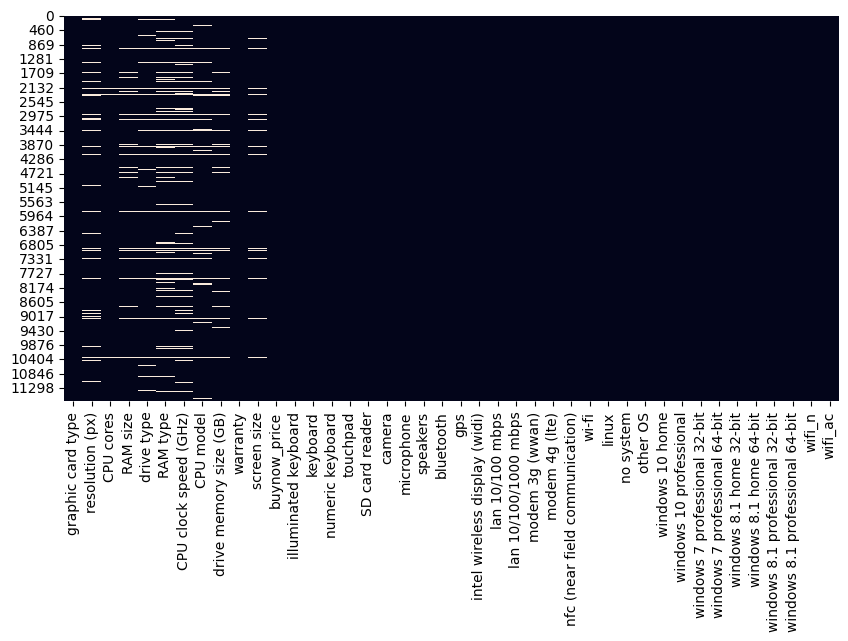

In [13]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_dt.sort_index().isnull(), cbar=False)

In [14]:
pd.concat(
    [train_dt.isna().sum(), train_dt.isna().mean()],
    axis=1,
    keys=["Count", "Proportion"],
)

,Count,Proportion
graphic card type,0,0.000000
resolution (px),351,0.074506
CPU cores,47,0.009977
RAM size,254,0.053916
drive type,257,0.054553
RAM type,499,0.105922
CPU clock speed (GHz),530,0.112503
CPU model,322,0.068351
drive memory size (GB),272,0.057737
warranty,0,0.000000


Univariate Analysis

In [15]:
print(train_dt[numvars[:12]].describe(percentiles=[0.95]))
print(train_dt[numvars[12:24]].describe(percentiles=[0.95]))
print(train_dt[numvars[24:]].describe(percentiles=[0.95]))

       resolution (px)    CPU cores     RAM size  CPU clock speed (GHz)  \
count      4360.000000  4664.000000  4457.000000            4181.000000   
mean       1788.120183     2.771441     9.904420               2.342057   
std         388.567518     0.977152     6.664223               0.386298   
min        1280.000000     1.000000     2.000000               0.800000   
50%        1920.000000     2.000000     8.000000               2.500000   
95%        1920.000000     4.000000    20.000000               2.800000   
max        3840.000000     8.000000    64.000000               3.900000   

       drive memory size (GB)  screen size  buynow_price  \
count             4439.000000  4514.000000   4711.000000   
mean               652.619284    14.969118   3495.831195   
std                467.657354     1.003984   1727.933306   
min                  0.000000    11.900000    429.000000   
50%                500.000000    15.000000   3184.000000   
95%               1500.000000    17.000

In [16]:
for i in catvars:
    print(f"{i}: {train_dt[i].nunique()} {train_dt[i].unique()}")

graphic card type: 3 ['dedicated graphics' 'None' 'integrated graphics']
drive type: 5 ['ssd + hdd' 'ssd' 'hdd' None 'emmc' 'hybrid']
RAM type: 3 ['ddr4' 'ddr3' None 'ddr3l']
CPU model: 18 ['intel core i7' None 'other CPU' 'intel core i3' 'intel core i5'
 'intel celeron dual-core' 'intel pentium 4' 'intel celeron quad core '
 'amd a6' 'intel celeron ' 'intel pentium dual-core' 'amd a12' 'amd a8'
 'intel pentium quad-core ' 'intel core m' 'amd a4' 'intel celeron m'
 'amd a10' 'amd e1']
warranty: 3 ['producer warranty' 'seller warranty' 'no warranty']


In [17]:
train_dt["buynow_price"].describe(percentiles=[0.95])
train_dt[train_dt["buynow_price"] > 15000]

,graphic card type,resolution (px),CPU cores,RAM size,drive type,RAM type,CPU clock speed (GHz),CPU model,drive memory size (GB),warranty,...,windows 10 home,windows 10 professional,windows 7 professional 32-bit,windows 7 professional 64-bit,windows 8.1 home 32-bit,windows 8.1 home 64-bit,windows 8.1 professional 32-bit,windows 8.1 professional 64-bit,wifi_n,wifi_ac
2037,integrated graphics,2560.0,2.0,16.0,ssd,None,NaN,intel core i7,512.0,producer warranty,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10457,dedicated graphics,3840.0,4.0,16.0,ssd,ddr4,2.9,intel core i7,512.0,producer warranty,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='buynow_price'>

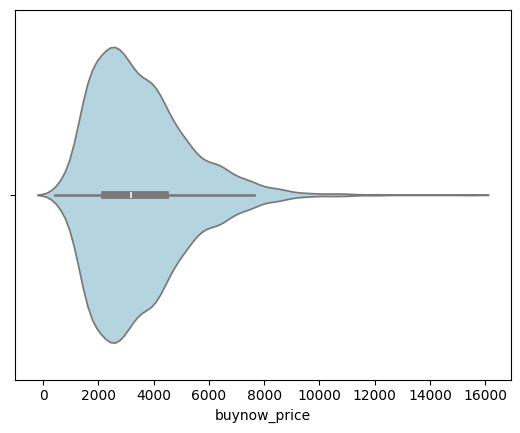

In [18]:
sns.violinplot(train_dt, x="buynow_price", color="lightblue")

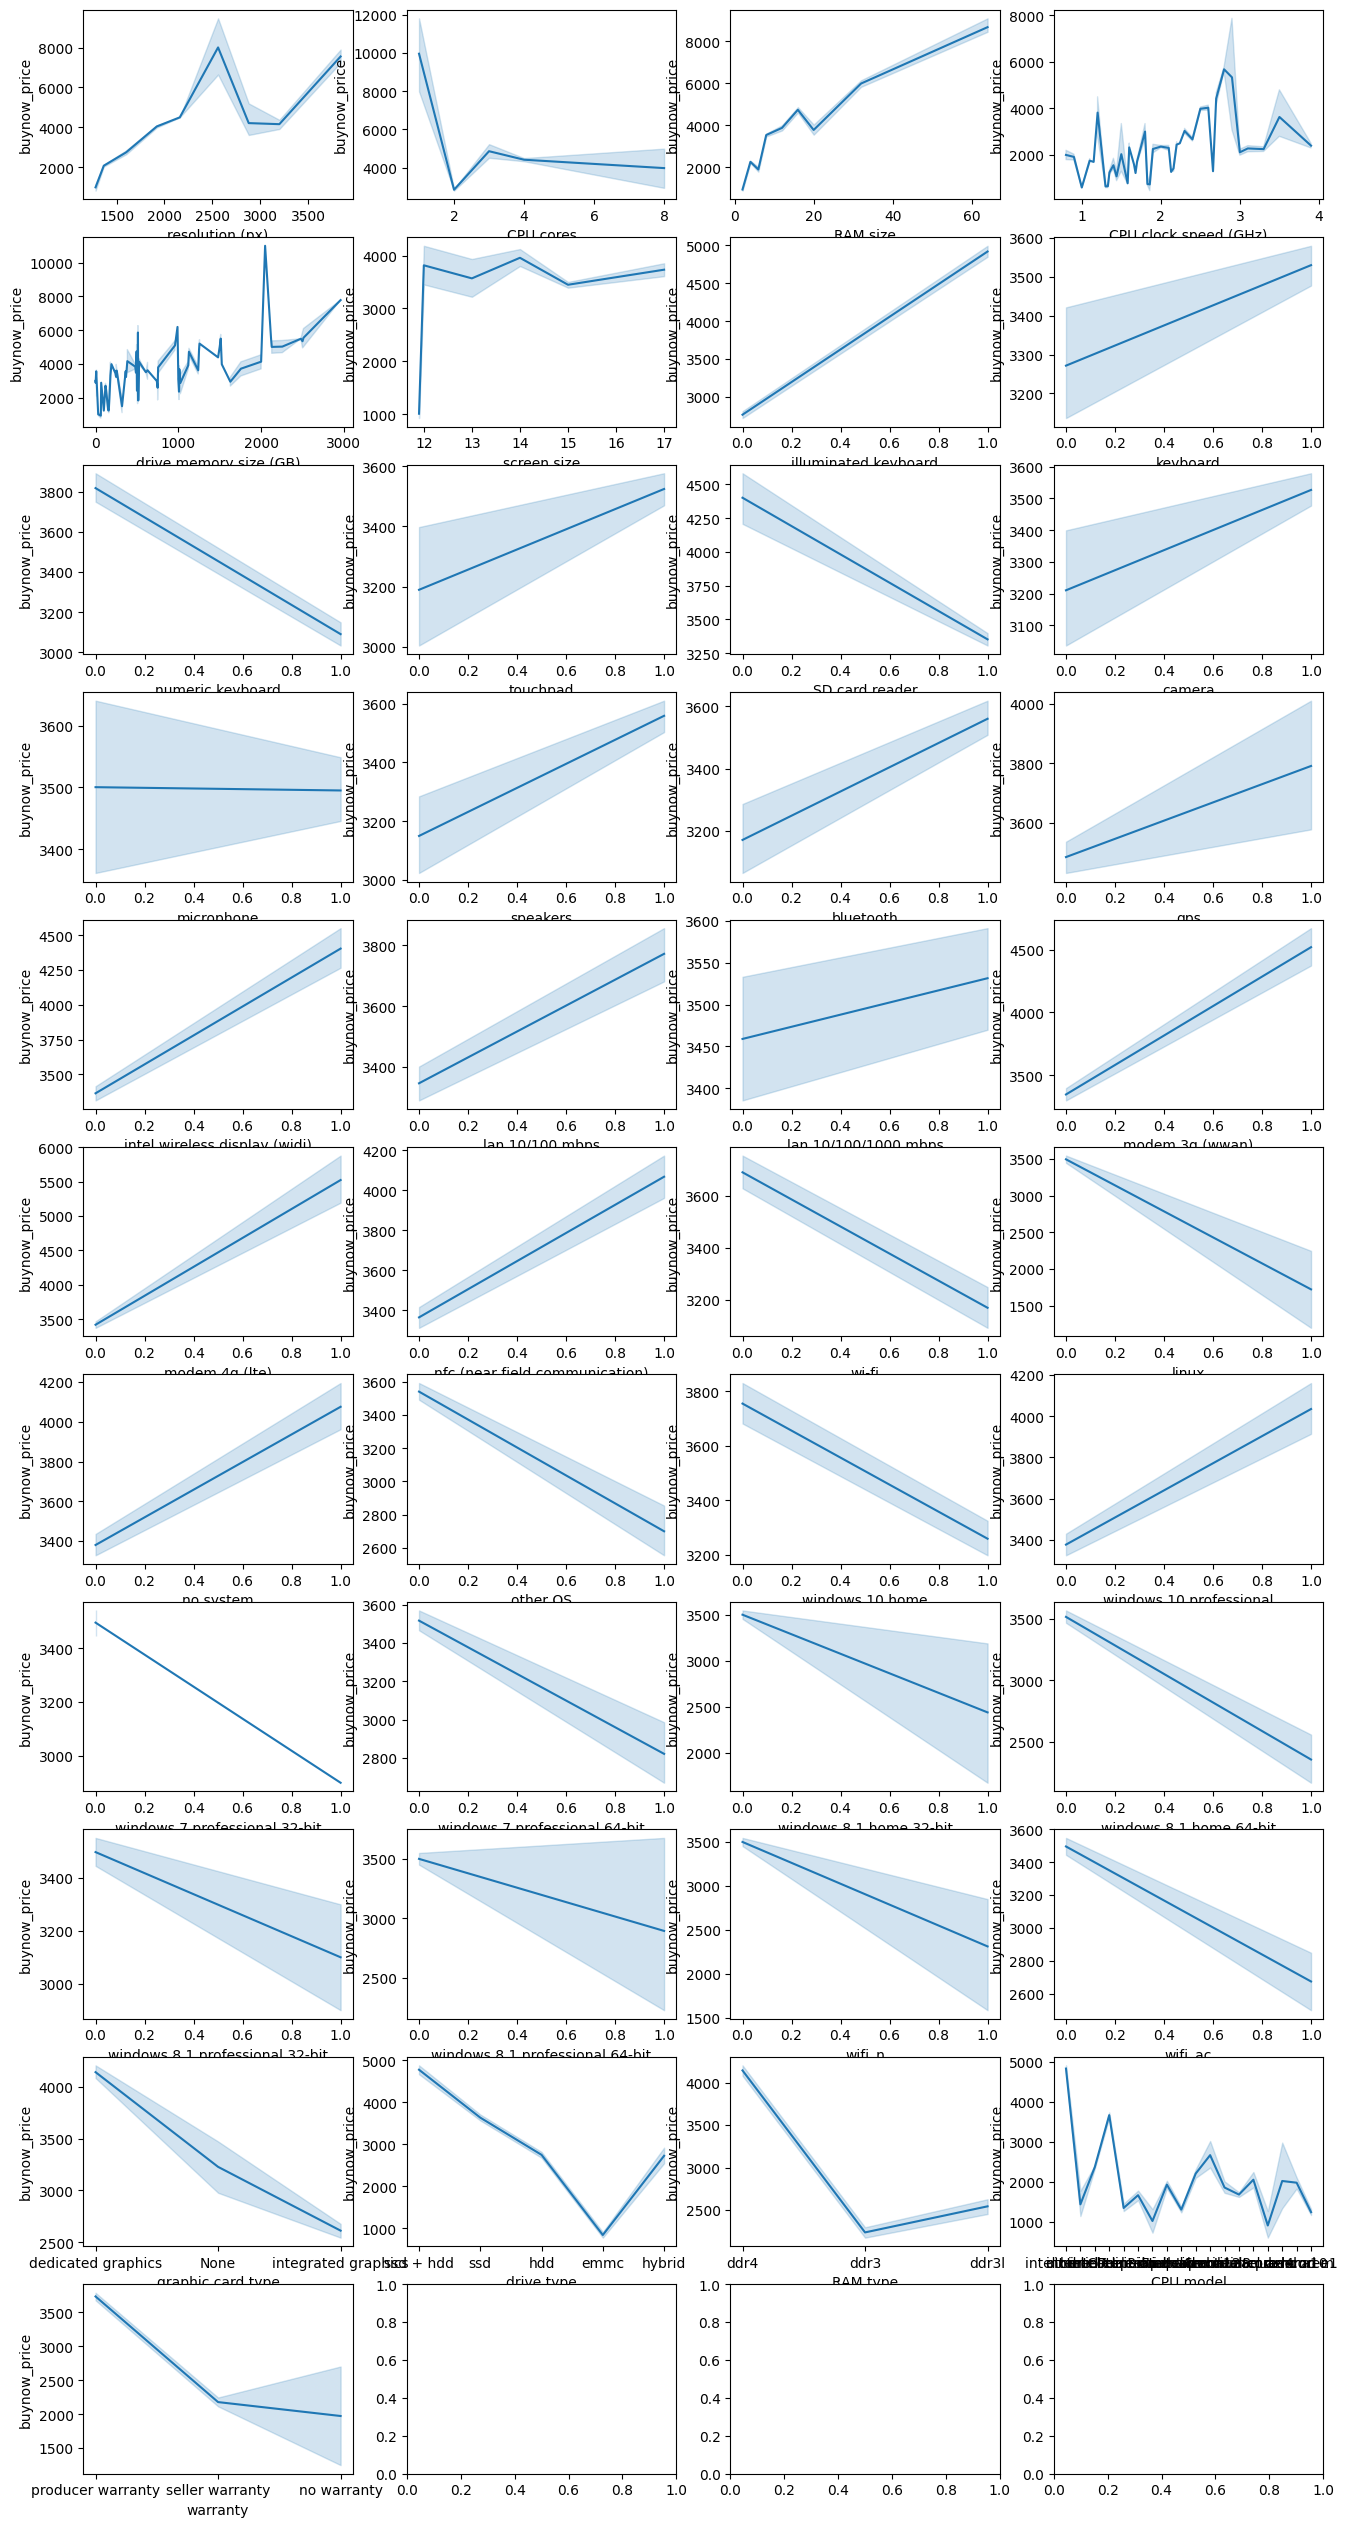

In [33]:
allvars = numvars + catvars
fig, axes = plt.subplots(ncols=4, nrows=len(allvars) // 4 + 1, figsize=(16, 32))
for i, var in enumerate([x for x in allvars if x != "buynow_price"]):
    sns.lineplot(train_dt, x=var, y="buynow_price", ax=axes[i // 4, i % 4])

## (4) xGBoost

In [20]:
numFeatures = [i for i in numvars if i != "buynow_price"]
catFeatures = catvars
target = "buynow_price"

In [21]:
catPipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(sparse_output=False, drop="first")),
    ]
)
numPipeline = Pipeline([("imputer", SimpleImputer(strategy="mean"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numPipeline, numFeatures),
        ("cat", catPipeline, catFeatures),
    ],
    remainder="drop",
)

In [22]:
val_dt["windows 7 professional 32-bit"] = 0
val_dt["windows 8.1 professional 32-bit"] = 0
val_dt["linux"] = 0
test_dt["linux"] = 0

In [23]:
X_train = preprocessor.fit_transform(train_dt)
X_val = preprocessor.transform(val_dt)
X_test = preprocessor.transform(test_dt)

y_train = train_dt[target]
y_val = val_dt[target]
y_test = test_dt[target]

In [24]:
params = {
    "eta": [0.05, 0.1, 0.3],
    "max_depth": [5, 7, 9],
    "subsample": [0.7, 0.85, 1],
    "reg_lambda": [2, 3, 4],
}

xgb = XGBRegressor(n_estimators=500, objective="reg:squarederror", eval_metric="rmse")

grid_search = GridSearchCV(xgb, param_grid=params, n_jobs=-1, cv=5)

In [25]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.05, 0.1, 0.3], 'max_depth': [5, 7, 9],
                         'reg_lambda': [2, 3, 4], 'subsample': [0.7, 0.85, 1]})

In [26]:
print(f"grid search best params: {grid_search.best_params_}")

grid search best params: {'eta': 0.1, 'max_depth': 7, 'reg_lambda': 3, 'subsample': 0.85}


In [27]:
xgb2 = XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=100,
    objective="reg:squarederror",
    eval_metric="rmse",
    **grid_search.best_params_,
)

xgb2.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=100,
)

print(f"xgb2.best_iteration: {xgb2.best_iteration}")

[0]	validation_0-rmse:1590.06936
[100]	validation_0-rmse:632.51208
[200]	validation_0-rmse:616.76463
[300]	validation_0-rmse:612.60314
[400]	validation_0-rmse:612.50785
[450]	validation_0-rmse:612.70031
xgb2.best_iteration: 351


In [28]:
# Evaluation
y_test_hat = xgb2.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_test_hat)}")
print(f"R2: {r2_score(y_test, y_test_hat)}")

RMSE: 667.0133887905689
R2: 0.8565253024828645


<Axes: xlabel='buynow_price'>

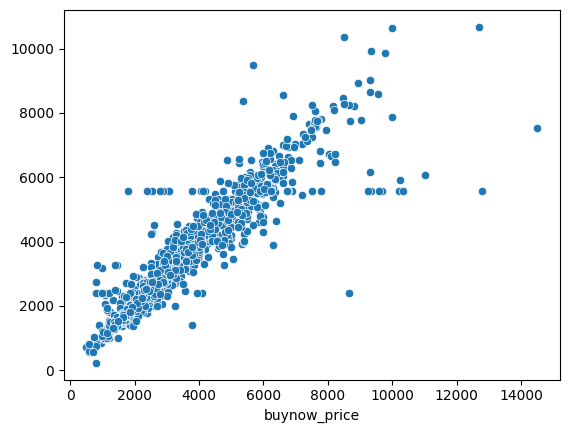

In [29]:
sns.scatterplot(x=y_test, y=y_test_hat)

## (5) Model interpretation

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

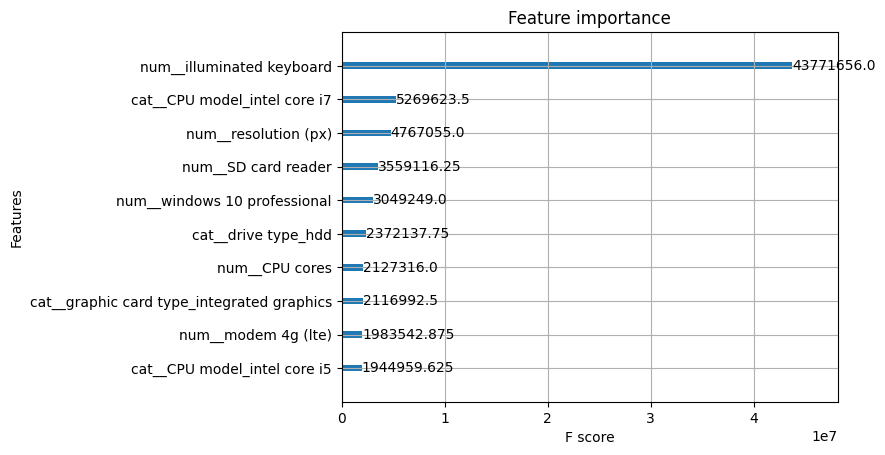

In [40]:
plot_importance(xgb2, importance_type="gain", max_num_features=10)

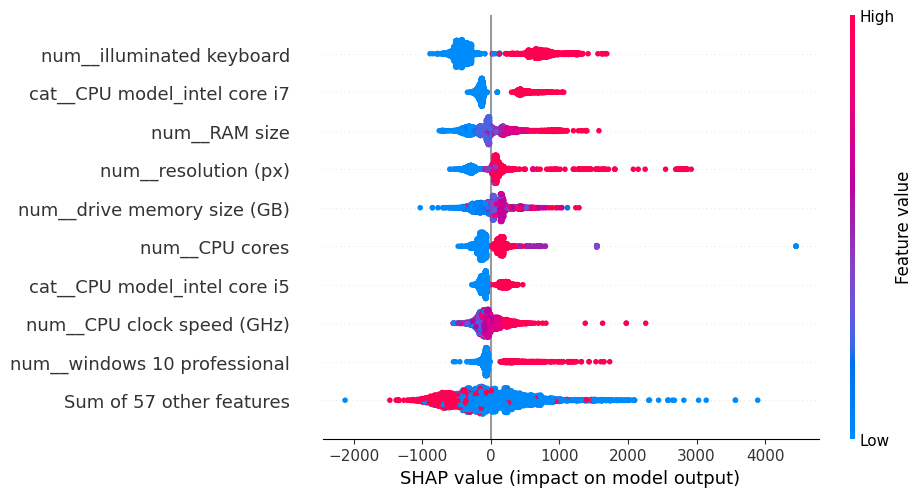

In [38]:
xgb_explainer = shap.TreeExplainer(xgb2)
shap_values = xgb_explainer(X_train)

shap.plots.beeswarm(shap_values)

In [ ]:
feature_importances = xgb2.get_booster().get_score(importance_type="gain")
feature_importances = (
    pd.DataFrame.from_dict(feature_importances, orient="index", columns=["importance"])
    .sort_values("importance", ascending=False)
    .reset_index()
)

In [66]:
feature_importances

,index,importance
0,num__illuminated keyboard,4.377166e+07
1,cat__CPU model_intel core i7,5.269624e+06
2,num__resolution (px),4.767055e+06
3,num__SD card reader,3.559116e+06
4,num__windows 10 professional,3.049249e+06
...,...,...
60,num__linux,5.216000e+04
61,cat__CPU model_amd a12,4.111599e+04
62,cat__CPU model_intel celeron m,2.302262e+04
63,num__windows 8.1 professional 32-bit,1.843516e+04


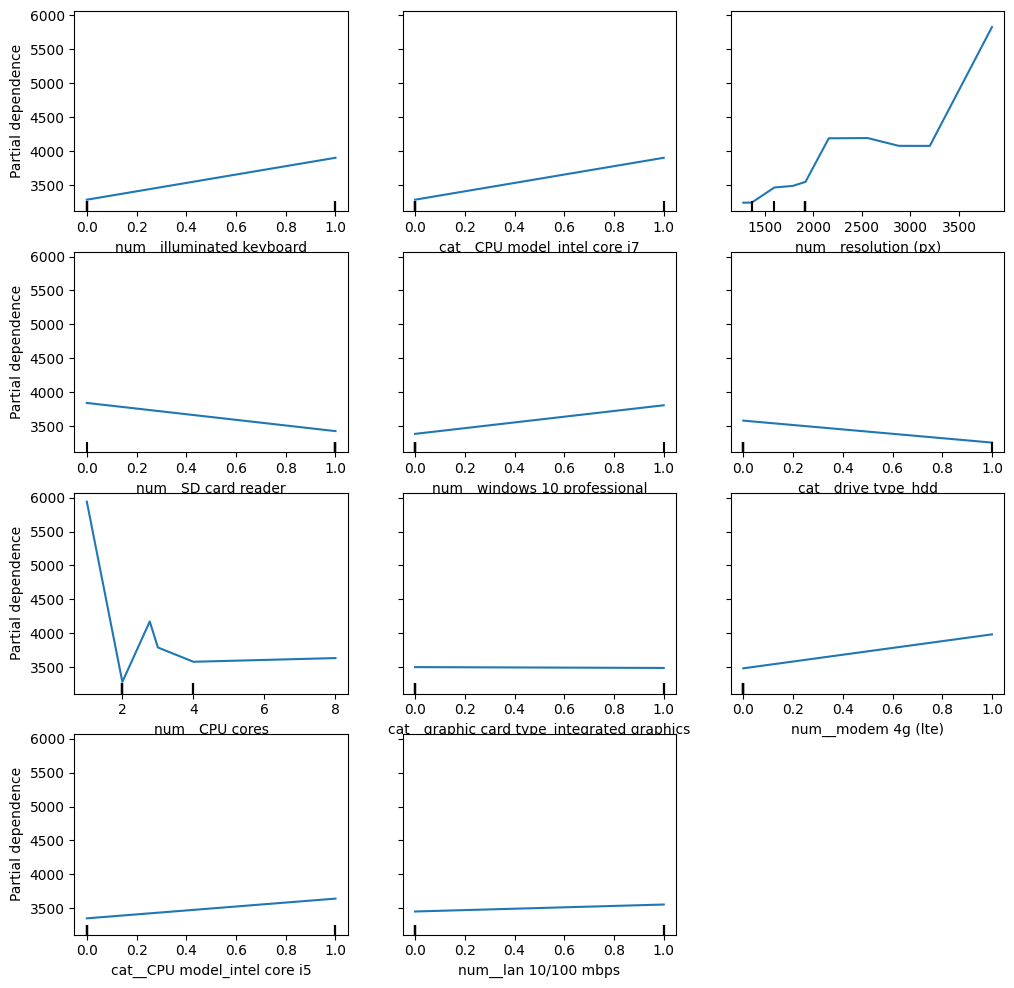

In [73]:
pdp = PartialDependenceDisplay.from_estimator(
    xgb2, X_train, features=feature_importances.loc[0:10, "index"]
)
pdp.figure_.set_size_inches(12, 12)

## (6) Decision Tree

In [ ]:
dtreg = DecisionTreeRegressor(random_state=777)

param_grid = {
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    dtreg, param_grid, cv=5, scoring="neg_root_mean_squared_error"
)
grid_search.fit(X_train, y_train)
print(f"grid search best params: {grid_search.best_params_}")
dtreg2 = grid_search.best_estimator_

grid search best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [85]:
# Evaluation
y_test_hat = dtreg2.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, y_test_hat)}")
print(f"R2: {r2_score(y_test, y_test_hat)}")

RMSE: 832.4740460345834
R2: 0.7765153908381681


[Text(0.5, 0.875, 'num__illuminated keyboard <= 0.5\nsquared_error = 2985119.726\nsamples = 4711\nvalue = 3495.831'),
 Text(0.25, 0.625, 'num__resolution (px) <= 3520.0\nsquared_error = 1769321.646\nsamples = 3114\nvalue = 2765.998'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'num__resolution (px) <= 1483.0\nsquared_error = 1418152.61\nsamples = 3074\nvalue = 2697.28'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'num__RAM size <= 24.0\nsquared_error = 505308.697\nsamples = 40\nvalue = 8046.95'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'num__CPU clock speed (GHz) <= 2.65\nsquared_error = 2291946.785\nsamples = 1597\nvalue = 4918.938'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'num__SD card reader <= 0.5\nsquared_error = 1964693.931\nsamples = 1018\nvalue = 4510.131'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0

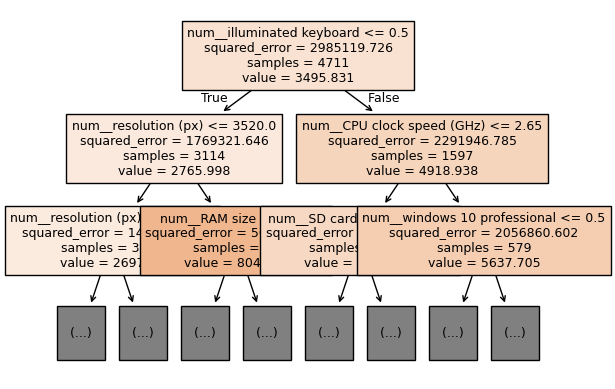

In [88]:
plot_tree(dtreg2, feature_names=X_train.columns, max_depth=2, filled=True, fontsize=9)